In [1]:
!pip install pandas numpy yfinance scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 685.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 1.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.6/425.6 kB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.7/157.7 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.18.2-cp310-cp310-macosx_11_0_arm64.whl size=268692 sha256=37e1f067e26af1944df189a703dda5d53d09d5b6548877384aebdc06824f105e
  Stored in directory: /Users/nijat/Library/Caches/pip/wheels/ba/6c/45/466c8

In [3]:
import pandas as pd

# Load momentum factor (UMD)
momentum_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
momentum_df = pd.read_csv(momentum_url, skiprows=13)
momentum_df = momentum_df[momentum_df.columns[0:2]]  # Keep only date + momentum
momentum_df.columns = ['Date', 'Momentum']
momentum_df = momentum_df[momentum_df['Date'].str.len() == 6]  # Filter valid dates
momentum_df['Date'] = pd.to_datetime(momentum_df['Date'], format='%Y%m')
momentum_df['Momentum'] = pd.to_numeric(momentum_df['Momentum'], errors='coerce')  # Convert to float
momentum_df = momentum_df.dropna()
momentum_df.set_index('Date', inplace=True)
momentum_df = momentum_df.loc['2000-01':'2024-12'] / 100

# Load value factor (HML)
value_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
value_df = pd.read_csv(value_url, skiprows=3)
value_df = value_df[value_df.columns[0:5]]
value_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
value_df = value_df[value_df['Date'].astype(str).str.len() == 6]
value_df['Date'] = pd.to_datetime(value_df['Date'], format='%Y%m')
value_df['HML'] = pd.to_numeric(value_df['HML'], errors='coerce')
value_df = value_df.dropna()
value_df.set_index('Date', inplace=True)
value_df = value_df.loc['2000-01':'2024-12'][['HML']] / 100

# Merge factors
factors = momentum_df.join(value_df, how='inner')
factors.columns = ['Momentum', 'Value']
factors.head()


,Momentum,Value
Date,,
2000-01-01,0.0186,-0.0112
2000-02-01,0.1800,-0.0977
2000-03-01,-0.0685,0.0850
2000-04-01,-0.0860,0.0645
2000-05-01,-0.0899,0.0459


In [5]:
import yfinance as yf

# Get VIX monthly closing prices
vix_raw = yf.download("^VIX", start="2000-01-01", end="2024-12-31", interval='1mo', auto_adjust=False)
vix = vix_raw[['Close']].copy()
vix.columns = ['VIX']

# Get S&P 500 monthly returns
sp500_raw = yf.download("^GSPC", start="2000-01-01", end="2024-12-31", interval='1mo', auto_adjust=False)
sp500 = sp500_raw[['Close']].pct_change()
sp500.columns = ['SP500_Return']

# Join with factor data
data = factors.join([vix, sp500], how='inner')
data.dropna(inplace=True)
data.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Momentum,Value,VIX,SP500_Return
Date,,,,
2000-02-01,0.1800,-0.0977,23.370001,-0.020108
2000-03-01,-0.0685,0.0850,24.110001,0.096720
2000-04-01,-0.0860,0.0645,26.200001,-0.030796
2000-05-01,-0.0899,0.0459,23.650000,-0.021915
2000-06-01,0.1660,-0.0804,19.540001,0.023934


In [6]:
# Create lagged features (1-month lag)
data['Momentum_lag1'] = data['Momentum'].shift(1)
data['Value_lag1'] = data['Value'].shift(1)
data['VIX_lag1'] = data['VIX'].shift(1)
data['SP500_lag1'] = data['SP500_Return'].shift(1)

# Drop missing rows after shifting
data = data.dropna()
data.head()


,Momentum,Value,VIX,SP500_Return,Momentum_lag1,Value_lag1,VIX_lag1,SP500_lag1
Date,,,,,,,,
2000-03-01,-0.0685,0.0850,24.110001,0.096720,0.1800,-0.0977,23.370001,-0.020108
2000-04-01,-0.0860,0.0645,26.200001,-0.030796,-0.0685,0.0850,24.110001,0.096720
2000-05-01,-0.0899,0.0459,23.650000,-0.021915,-0.0860,0.0645,26.200001,-0.030796
2000-06-01,0.1660,-0.0804,19.540001,0.023934,-0.0899,0.0459,23.650000,-0.021915
2000-07-01,-0.0016,0.0806,20.740000,-0.016341,0.1660,-0.0804,19.540001,0.023934


In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['Momentum_lag1', 'Value_lag1', 'VIX_lag1', 'SP500_lag1']
target = 'Momentum'

X = data[features]
y = data[target]

# Train/test split (keep time order — no shuffle!)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Print performance
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred, squared=False), 4))


R² Score: -0.0119
RMSE: 0.0467


In [8]:
import numpy as np

# Predict for the full dataset (for backtest)
data['Predicted_Momentum'] = model.predict(X)

# Strategy A: dynamic exposure based on prediction
data['Dynamic_Return'] = data.apply(lambda row: row['Momentum'] if row['Predicted_Momentum'] > 0 else 0, axis=1)

# Strategy B: static exposure (always long momentum)
data['Static_Return'] = data['Momentum']

# Sharpe ratio calculation
def sharpe_ratio(series):
    return (np.mean(series) / np.std(series)) * np.sqrt(12)  # Annualized

# Performance summary
print("Dynamic Sharpe:", round(sharpe_ratio(data['Dynamic_Return']), 3))
print("Static Sharpe: ", round(sharpe_ratio(data['Static_Return']), 3))
print("\nDynamic Mean Monthly Return:", round(data['Dynamic_Return'].mean(), 4))
print("Static Mean Monthly Return: ", round(data['Static_Return'].mean(), 4))


Dynamic Sharpe: 0.355
Static Sharpe:  0.054

Dynamic Mean Monthly Return: 0.0028
Static Mean Monthly Return:  0.0008


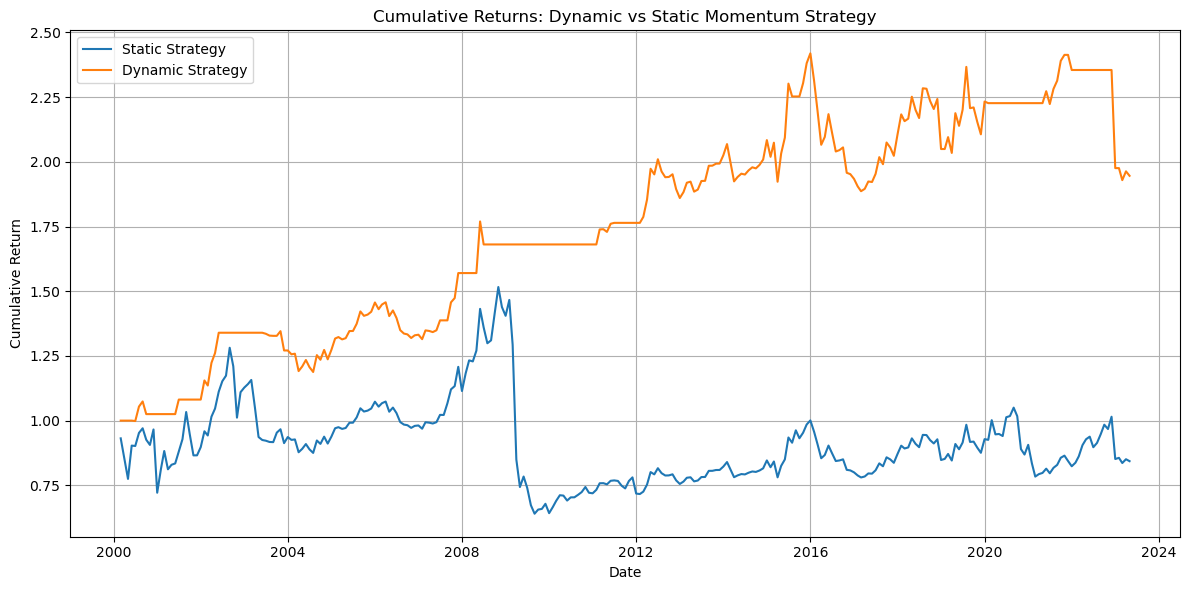

In [9]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
data['Cumulative_Static'] = (1 + data['Static_Return']).cumprod()
data['Cumulative_Dynamic'] = (1 + data['Dynamic_Return']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Static'], label='Static Strategy')
plt.plot(data.index, data['Cumulative_Dynamic'], label='Dynamic Strategy')
plt.title('Cumulative Returns: Dynamic vs Static Momentum Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


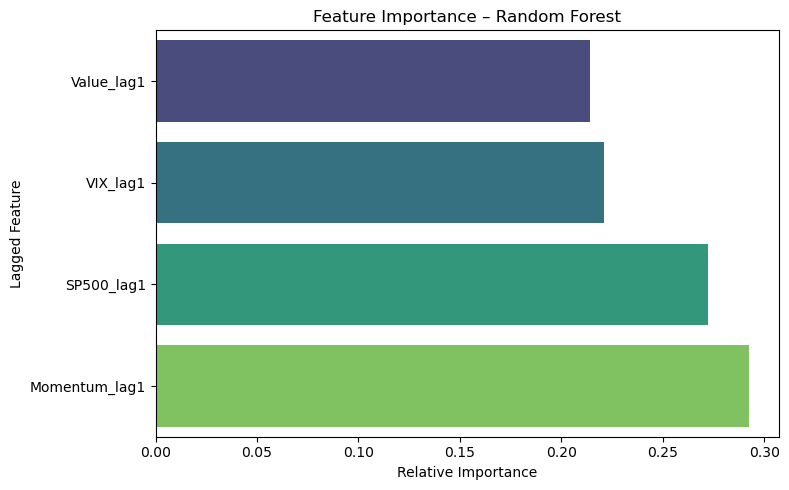

In [10]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance – Random Forest')
plt.xlabel('Relative Importance')
plt.ylabel('Lagged Feature')
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

# Ridge + alpha grid
from sklearn.linear_model import Ridge
ridge = Ridge()

# Test a few alpha values (regularization strength)
params = {'alpha': [0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]}

# Use 5-fold time-series CV
ridge_cv = GridSearchCV(estimator=ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

# Best model and performance
best_ridge = ridge_cv.best_estimator_
best_alpha = ridge_cv.best_params_['alpha']
print("Best Ridge Alpha:", best_alpha)

# Predict and evaluate on test set
y_pred_cv = best_ridge.predict(X_test)
print("R² (CV-Tuned):", round(r2_score(y_test, y_pred_cv), 4))
print("RMSE (CV-Tuned):", round(mean_squared_error(y_test, y_pred_cv, squared=False), 4))


Best Ridge Alpha: 100.0
R² (CV-Tuned): 0.0277
RMSE (CV-Tuned): 0.0458
